In [1]:
# include the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import plotly.express as px
from neato import Genome
o_df = pd.read_csv("Mobile Device Data.csv")
y_df = o_df["Release Year"]
df = o_df.select_dtypes(include=np.number)
df = df.drop(columns= ["Model ID", "Release Year"])
df.head()

,Release Year,RAM Capacity (Mb),Storage (Mb),CPU Clock (MHz),Display Diagonal (in),Display Width(px),Display Length(px),Width (mm),Length (mm),Depth (mm),Volume (cubic cm),Mass (grams),Pixel Density (per inch)
0,1989.000000,0.000000,0.000000,0.000000,0.050360,0.000000,0.000000,0.369714,0.118852,0.146889,0.059332,0.044181,0.000000
1,1991.250000,0.000214,0.000015,0.002230,0.223022,0.056911,0.047619,0.416098,0.147541,0.127646,0.065799,0.053879,0.030793
2,1991.416667,0.000092,0.000015,0.001895,0.187050,0.056911,0.023810,0.432469,0.147541,0.101988,0.056634,0.044181,0.035336
3,1992.000000,0.000458,0.000015,0.002230,0.223022,0.056911,0.047619,0.416098,0.147541,0.127646,0.065799,0.053879,0.030793
4,1993.166667,0.000214,0.000015,0.003386,0.258993,0.154472,0.063492,0.432469,0.147541,0.101988,0.056634,0.046336,0.129985


In [2]:
col_list = df.columns.values
col_list = list(col_list)
col_list
col_dict = {}
for i in col_list:
  col_dict[i] = i

col_dict

{'Release Year': 'Release Year',
 'RAM Capacity (Mb)': 'RAM Capacity (Mb)',
 'Storage (Mb)': 'Storage (Mb)',
 'CPU Clock (MHz)': 'CPU Clock (MHz)',
 'Display Diagonal (in)': 'Display Diagonal (in)',
 'Display Width(px)': 'Display Width(px)',
 'Display Length(px)': 'Display Length(px)',
 'Width (mm)': 'Width (mm)',
 'Length (mm)': 'Length (mm)',
 'Depth (mm)': 'Depth (mm)',
 'Volume (cubic cm)': 'Volume (cubic cm)',
 'Mass (grams)': 'Mass (grams)',
 'Pixel Density (per inch)': 'Pixel Density (per inch)'}

In [3]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
similarity_matrix = df.corr()

In [4]:
similarity_matrix.shape

(13, 13)

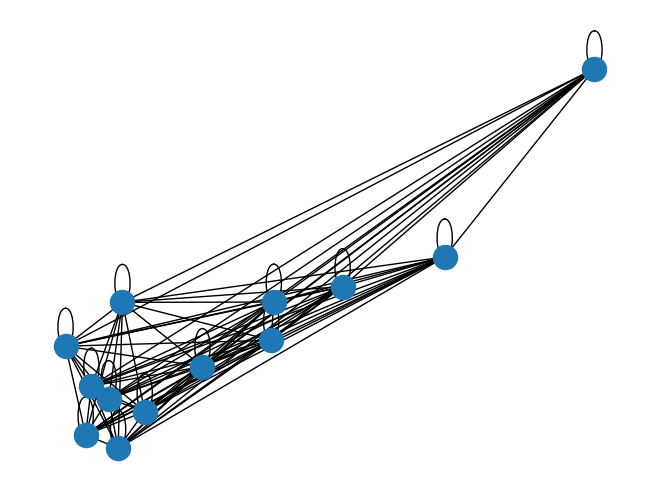

In [5]:
# create nx graph from sim matrix
G = nx.to_networkx_graph(similarity_matrix)
nx.draw(G)

In [6]:
def create_node_trace(G):
    # collect node information from G to plot
    node_x = []
    node_y = []
    node_text = []
    node_color = []

    for i, node in enumerate(G.nodes(data=True)):
        # get node x,y position and store
        x, y = node[1]['pos']
        node_x.append(x)
        node_y.append(y)

        node_text.append(node[1]['text'])
        node_color.append(node[1]['color'])

    # create node trace (i.e., scatter plot)
    # make it invisible by default
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=16,
            line_width=0.5,
        ),
        text=node_text,
        visible=False
    )

    return node_trace

In [7]:
def create_edge_trace(G):
    # collect edges information from G to plot
    edge_weight = []
    edge_text = []
    edge_pos = []
    edge_color = []
    
    for edge in G.edges(data=True):
        
        # edge is line connecting two points
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_pos.append([[x0, x1, None], [y0, y1, None]])
        
        # edge line color when drawn
        edge_color.append("black")

    # there is a trace for each edge
    edge_traces = []
    for i in range(len(edge_pos)):
        
        # edge line width
        line_width = 1

        # is scatter because it is line connecting two points
        trace = go.Scatter(
            x=edge_pos[i][0], y=edge_pos[i][1],
            line=dict(width=line_width, color=edge_color[i]),
            mode='lines',
            visible=False
        )
        edge_traces.append(trace)

    return edge_traces

In [8]:
def filter_similarity_matrix_at_step(square_matrix, step_value):
    # copy matrix
    aux = square_matrix.copy()
    
    # set as NaN all values equal to or below threshold value
    aux[aux <= step_value] = np.nan
    
    # return filtered matrix
    return aux

In [9]:
def get_interactive_slider_similarity_graph(square_matrix, slider_values, node_text=None, yaxisrange=None, xaxisrange=None):
    
    # Create figure with plotly
    fig = go.Figure()

    # key: slider value
    # value: list of traces to display for that slider value
    slider_dict = {}
    
    # total number of traces
    total_n_traces = 0
    
    # node positions on plot
    #node_pos = None

    # for each possible value in the slider, create and store traces (i.e., plots)
    for i, step_value in enumerate(slider_values):

        # update similarity matrix for the current step
        aux = filter_similarity_matrix_at_step(square_matrix, step_value)

        # create nx graph from sim matrix
        G = nx.to_networkx_graph(aux)
        
        # remove edges for 0 weight (NaN)
        G.remove_edges_from([(a, b) for a, b, attrs in G.edges(data=True) if np.isnan(attrs["weight"])])

        # assign node positions if None
        node_pos = nx.nx_pydot.graphviz_layout(G)

        # populate nodes with meta information
        for node in G.nodes(data=True):
            
            # node position
            node[1]['pos'] = node_pos[node[0]]

            # node color
            node[1]['color'] = "orange"

            # node text on hover if any is specified else is empty
            if node_text is not None:
                node[1]['text'] = node_text[node[0]]
            else:
                node[1]['text'] = ""

        # create edge taces (each edge is a trace, thus this is a list)
        edge_traces = create_edge_trace(G)
        
        # create node trace (a single trace for all nodes, thus it is not a list)
        node_trace = create_node_trace(G) 

        # store edge+node traces as single list for the current step value
        slider_dict[step_value] = edge_traces + [node_trace]
        
        # keep count of the total number of traces
        total_n_traces += len(slider_dict[step_value])

        # make sure that the first slider value is active for visualization
        if i == 0:
            for trace in slider_dict[step_value]:
                # make visible
                trace.visible = True

                
    # Create steps objects (one step per step_value)
    steps = []
    for step_value in slider_values:
        
        # count traces before adding new traces
        n_traces_before_adding_new = len(fig.data)
        
        # add new traces
        fig.add_traces(slider_dict[step_value])

        step = dict(
            # update figure when this step is active
            method="update",
            # make all traces invisible
            args=[{"visible": [False] * total_n_traces}],
            # label on the slider
            label=str(round(step_value, 3)),
        )

        # only toggle this step's traces visible, others remain invisible
        n_traces_for_step_value = len(slider_dict[step_value])
        for i in range(n_traces_before_adding_new, n_traces_before_adding_new + n_traces_for_step_value):
            step["args"][0]["visible"][i] = True
        
        # store step object in list of many steps
        steps.append(step)

    # create slider with list of step objects
    slider = [dict(
        active=0,
        steps=steps
    )]

    # add slider to figure and create layout
    fig.update_layout(
        sliders=slider,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(range=xaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(range=yaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        width=700, height=700,
    )

    return fig

In [10]:
# define slider steps (i.e., threshold values)
slider_steps = np.arange(0.4, 0.85, 0.05)
    
# get the slider figure
fig = get_interactive_slider_similarity_graph(
    similarity_matrix,
    slider_steps,
    node_text = col_list
)

# plot it
fig.show()

FileNotFoundError: [Errno 2] "neato" not found in path.